In [3]:
# Libraries for file and directory operations
import os
import shutil
import glob
import random

# avoid warnings
import warnings 
warnings. filterwarnings('ignore')

# Library for data processing
import numpy as np
import math
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Libraries for deep learning model
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Dataset path
dataset_path = 'dataset3/'

# Define training and test folders
training_folder_path = 'dataset3/training/'
test_folder_path = 'dataset3/evaluation/'
val_folder_path = 'dataset3/validation/'

TRAIN_DIR = "dataset3/training/images/"
TEST_DIR = "dataset3/evaluation/images/"
VAL_DIR = "dataset3/validation/images/"

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

seed = 42
size = (224,224)

In [5]:
# Counting total labels
def count_labels(folder_path):
    label_count = 0
    for _, dirs, _ in os.walk(folder_path):
        label_count += len(dirs)
        break  # Only count the top-level directories and exit the loop
    return label_count

num_labels = count_labels(training_folder_path)
print(f"Number of labels (folders) in the training dataset: {num_labels}")

Number of labels (folders) in the training dataset: 3


In [6]:
# Get a list of all labels (subfolder names) within the training folder
labels = [label for label in os.listdir(training_folder_path) if os.path.isdir(os.path.join(training_folder_path, label))]

# Sort the labels alphabetically
sorted_labels = sorted(labels)

# Print the list of labels
print("Sorted Labels:")
for label in sorted_labels:
    print(label)

Sorted Labels:
egg
milk
seafood


In [7]:
training_subset = training_folder_path
test_subset = test_folder_path
val_subset = val_folder_path

# function to count images in each folder
def count_images_per_label(folder_path):
    label_counts = {
        label: len(os.listdir(os.path.join(folder_path, label)))
        for label in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, label))
    }

    return label_counts

if __name__ == "__main__":
    # Count images in training folders
    training_label_counts = count_images_per_label(training_subset)
    test_label_counts = count_images_per_label(test_subset)
    val_label_counts = count_images_per_label(val_subset)
    sorted_training_label_counts = sorted(training_label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_test_label_counts = sorted(test_label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_val_label_counts = sorted(val_label_counts.items(), key=lambda x: x[1], reverse=True)
print("\nTraining Label Counts (sorted by count):")
for label, count in sorted_training_label_counts:
    print(f"{label}: {count}")
print("\nTest Label Counts (sorted by count):")
for label, count in sorted_test_label_counts:
    print(f"{label}: {count}")
print("\nValidation Label Counts (sorted by count):")
for label, count in sorted_val_label_counts:
    print(f"{label}: {count}")


Training Label Counts (sorted by count):
egg: 986
milk: 872
seafood: 855

Test Label Counts (sorted by count):
seafood: 347
egg: 335
milk: 205

Validation Label Counts (sorted by count):
seafood: 347
egg: 327
milk: 253


In [8]:
#counting number of images
def count_total_images(folder_path):
    total_images = 0
    for _, _, files in os.walk(folder_path):
        total_images += len(files)
    return total_images

total_images_count = count_total_images(dataset_path)
total_train_images_count = count_total_images(training_subset)
total_test_images_count = count_total_images(test_subset)
total_val_images_count = count_total_images(val_subset)

#Display total number of images in each folder of the dataset
print(f"Total number of images in the dataset: {total_images_count}")
print(f"Total number of images in the training dataset: {total_train_images_count}")
print(f"Total number of images in the test dataset: {total_test_images_count}")
print(f"Total number of images in the validation dataset: {total_val_images_count}")

Total number of images in the dataset: 4527
Total number of images in the training dataset: 2713
Total number of images in the test dataset: 887
Total number of images in the validation dataset: 927


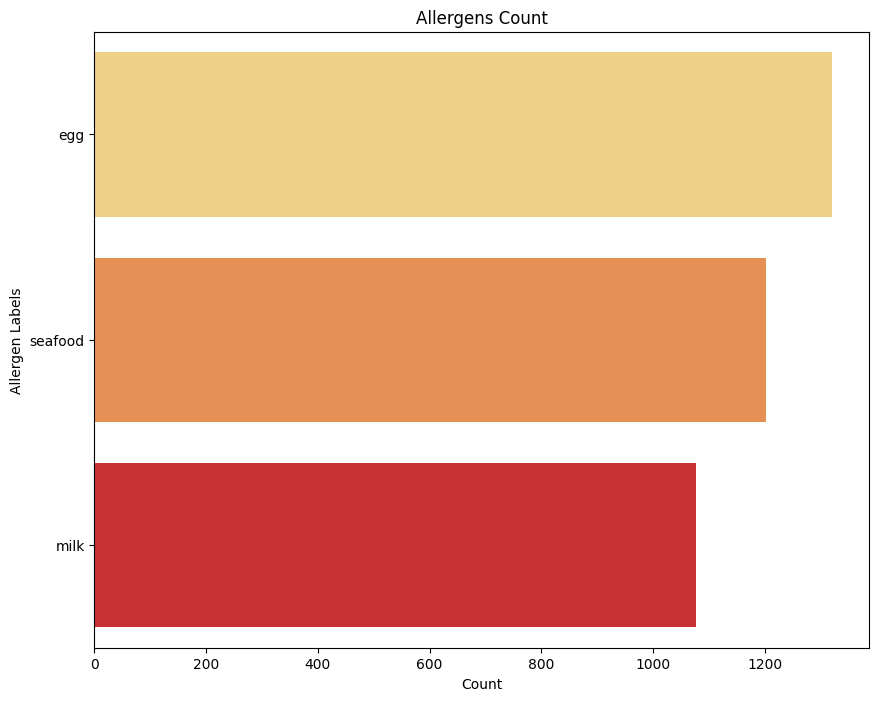

In [9]:
# Combine the training and test label counts into a single dictionary
combined_label_counts = {
    label: training_label_counts.get(label, 0) + test_label_counts.get(label, 0)
    for label in set(list(training_label_counts.keys()) + list(test_label_counts.keys()))
}

# Create a DataFrame to hold the allergen count
df_allergen_counts = pd.DataFrame({"Allergen Labels": list(combined_label_counts.keys()), "Count": list(combined_label_counts.values())})

# Sort the DataFrame by the counts in descending order
df_allergen_counts = df_allergen_counts.sort_values(by="Count", ascending=False)
allergen_count = df_allergen_counts.head(15)

# Plot the horizontal bar chart using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x="Count", y="Allergen Labels", data=allergen_count, palette="YlOrRd")
plt.xlabel("Count")
plt.ylabel("Allergen Labels")
plt.title("Allergens Count")
plt.show()

In [10]:
BATCH_SIZE = 64
IMAGE_SIZE = 224
CHANNELS = 3
num_epochs = 50

In [11]:
# Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
   rotation_range=40,
   width_shift_range=0.2,
   height_shift_range=0.2,
   shear_range=0.2,
   zoom_range=0.2,
   horizontal_flip=True,
   vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    training_subset,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',    
    shuffle=True,
    seed=42,
    class_mode='categorical')

Found 2713 images belonging to 3 classes.


In [10]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    val_subset,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 927 images belonging to 3 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_subset,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,    
    class_mode='categorical')

Found 887 images belonging to 3 classes.


In [13]:
labels = list(test_generator.class_indices.keys())
print(labels)

['egg', 'milk', 'seafood']


In [13]:
data_augmentation = tf.keras.Sequential([ 
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name='data_augmentation')

In [14]:
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

In [15]:
from keras.applications import VGG16 as vgg16
base_VGG16 = vgg16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [16]:
num_classes = len(labels)

In [17]:
# Add Extra Layers to Model
x=data_augmentation(tf.keras.Input(shape=(224, 224, 3)))
x=base_VGG16.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
x=Dropout(0.2)(x)
x=Dense(64,activation='relu')(x) 
x=Dropout(0.2)(x)
x=Dense(16,activation='relu')(x) 
x=Dropout(0.25)(x)
out=Dense(num_classes,activation='sigmoid')(x)
model_VGG16=Model(inputs=base_VGG16.input,outputs=out)

In [18]:
base_VGG16.trainable = False

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

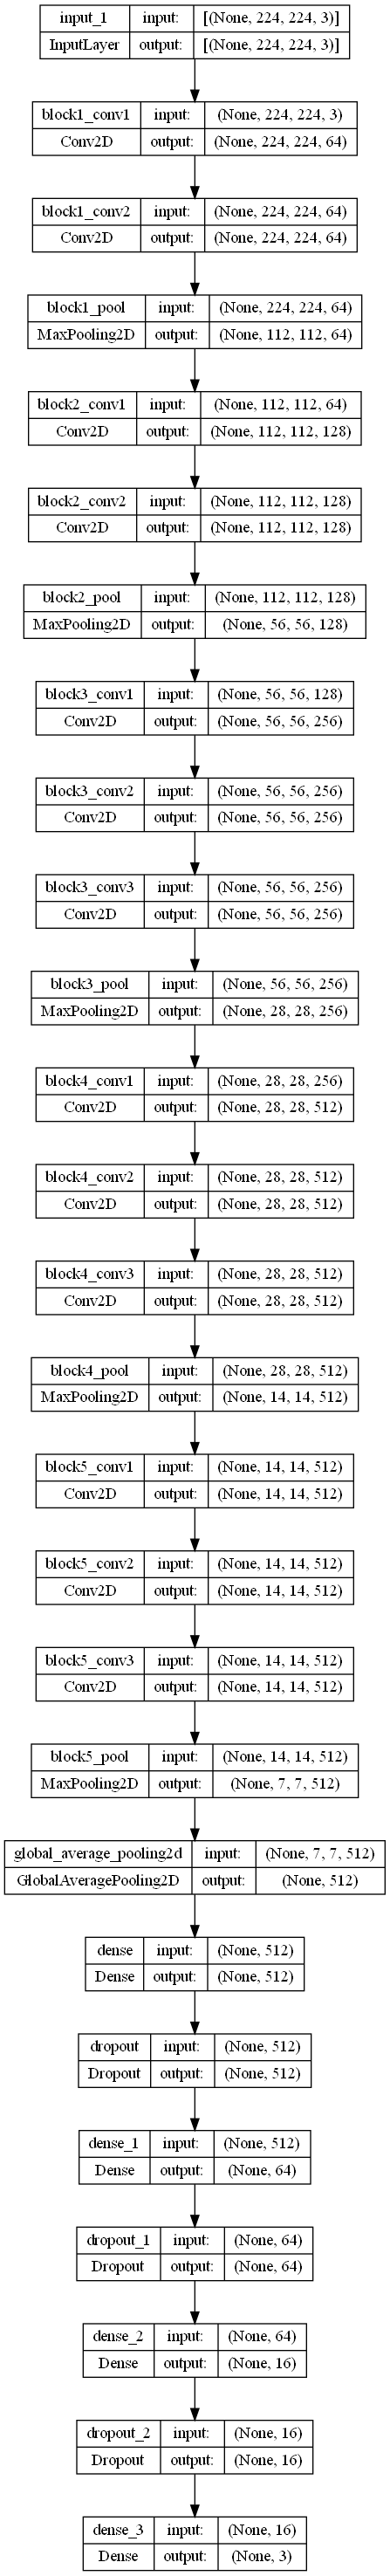

In [19]:
# Summary Model
model_VGG16.summary()
tf.keras.utils.plot_model(model_VGG16, show_shapes=True)

In [20]:
# Compile Model
model_VGG16.compile( 
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST =test_generator.n//test_generator.batch_size

history_VGG16 = model_VGG16.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=num_epochs, 
          validation_data=valid_generator, validation_steps=STEP_SIZE_VALID, callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/50
42/42 [==============================] - 248s 6s/step - loss: 1.0762 - accuracy: 0.4017 - val_loss: 0.9936 - val_accuracy: 0.5915
Epoch 2/50
42/42 [==============================] - 236s 6s/step - loss: 0.9710 - accuracy: 0.5217 - val_loss: 0.8685 - val_accuracy: 0.5915
Epoch 3/50
42/42 [==============================] - 237s 6s/step - loss: 0.8888 - accuracy: 0.5836 - val_loss: 0.8014 - val_accuracy: 0.6239
Epoch 4/50
42/42 [==============================] - 237s 6s/step - loss: 0.8311 - accuracy: 0.6097 - val_loss: 0.7610 - val_accuracy: 0.6518
Epoch 5/50
42/42 [==============================] - 226s 5s/step - loss: 0.7732 - accuracy: 0.6497 - val_loss: 0.7209 - val_accuracy: 0.6629
Epoch 6/50
42/42 [==============================] - 238s 6s/step - loss: 0.7452 - accuracy: 0.6589 - val_loss: 0.6970 - val_accuracy: 0.6830
Epoch 7/50
42/42 [==============================] - 230s 5s/step - loss: 0.7277 - accuracy: 0.6704 - val_loss: 0.6834 - val_accuracy: 0.7065
Epoch 8/50
42

In [22]:
# Evaluate Model VGG16
loss, acc = model_VGG16.evaluate(test_generator, steps=STEP_SIZE_TEST)
print("The accuracy of the model is {:.3f}\nThe Loss in the model is {:.3f}".format(acc,loss))

13/13 [==============================] - 51s 4s/step - loss: 0.4028 - accuracy: 0.8401
The accuracy of the model is 0.840
The Loss in the model is 0.403


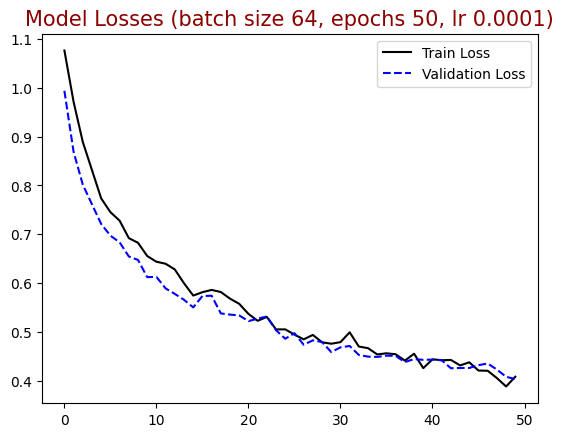

In [37]:
#Plotting train & validation loss
plt.figure()
plt.plot(history_VGG16.history["loss"],label = "Train Loss", color = "black")
plt.plot(history_VGG16.history["val_loss"],label = "Validation Loss", color = "blue", linestyle="dashed")
plt.title("Model Losses (batch size 64, epochs 50, lr 0.0001)", color = "darkred", size = 15)
plt.legend()
plt.show()

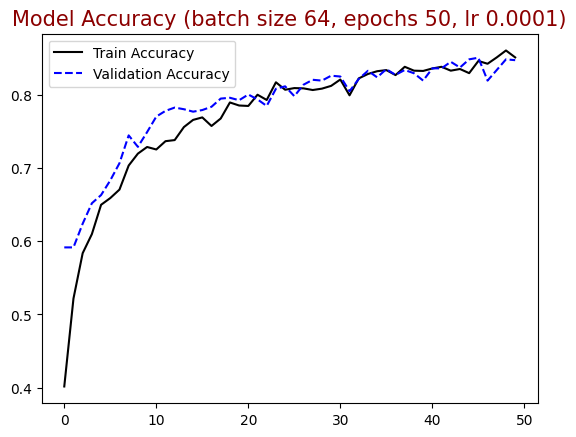

In [38]:
#Plotting train & validation accuracy
plt.figure()
plt.plot(history_VGG16.history["accuracy"],label = "Train Accuracy", color = "black")
plt.plot(history_VGG16.history["val_accuracy"],label = "Validation Accuracy", color = "blue", linestyle="dashed")
plt.title("Model Accuracy (batch size 64, epochs 50, lr 0.0001)", color = "darkred", size = 15)
plt.legend()
plt.show()

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

preds=model_VGG16.predict(test_generator)
y_pred = np.argmax(preds,axis=1)
y_actual = test_generator.classes
cm = confusion_matrix(y_actual, y_pred)
print(cm)

14/14 [==============================] - 57s 4s/step
[[292   8  35]
 [ 23 158  24]
 [ 33  15 299]]


In [26]:
import itertools

#Plot the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

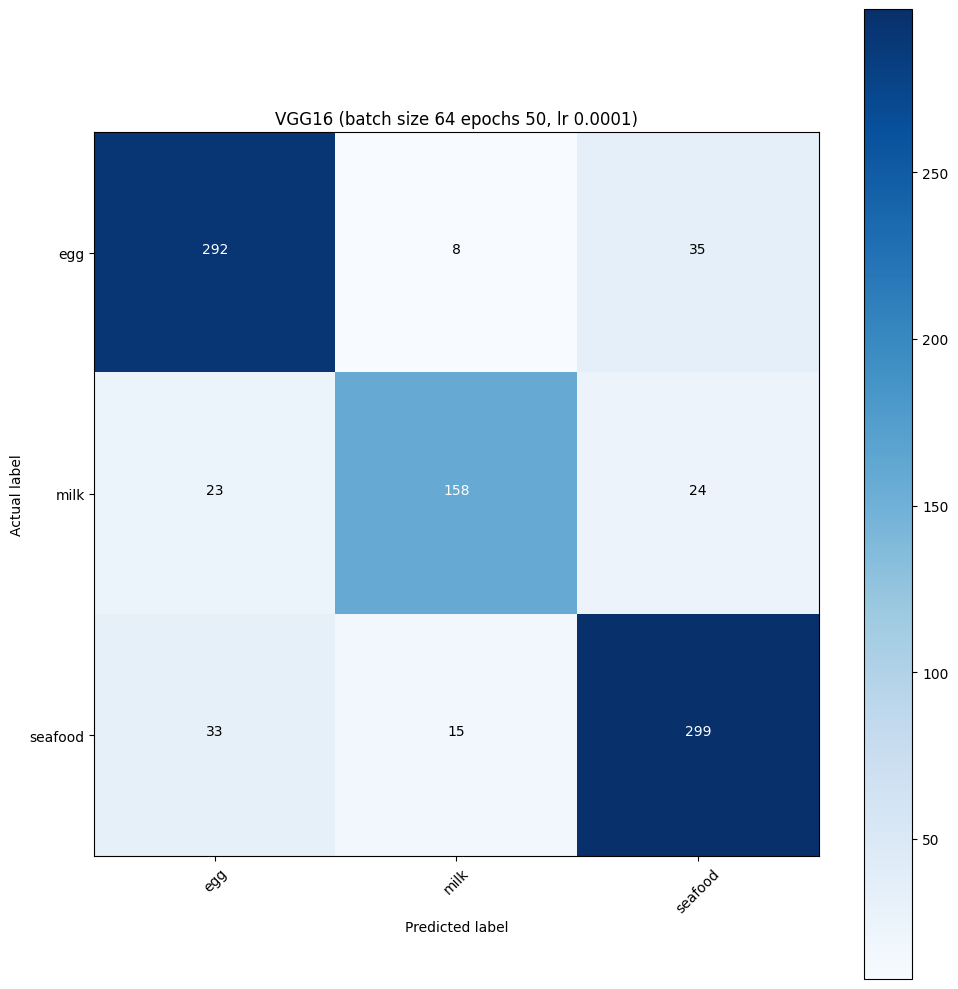

In [41]:
labels = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, labels, normalize=False, title='VGG16 (batch size 64 epochs 50, lr 0.0001)')

In [28]:
print(classification_report(y_actual, y_pred, target_names=labels))

              precision    recall  f1-score   support

         egg       0.84      0.87      0.86       335
        milk       0.87      0.77      0.82       205
     seafood       0.84      0.86      0.85       347

    accuracy                           0.84       887
   macro avg       0.85      0.83      0.84       887
weighted avg       0.85      0.84      0.84       887



In [29]:
def display_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)

In [30]:
display_classification_report(y_actual, y_pred, labels)

,precision,recall,f1-score,support
egg,0.839080,0.871642,0.855051,335.000000
milk,0.872928,0.770732,0.818653,205.000000
seafood,0.835196,0.861671,0.848227,347.000000
accuracy,0.844419,0.844419,0.844419,0.844419
macro avg,0.849068,0.834682,0.840644,887.000000
weighted avg,0.845383,0.844419,0.843969,887.000000


In [31]:
# test dataset pipeline
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   test_subset,
    seed=42,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 887 files belonging to 3 classes.


In [32]:
#print test labels
ts_class_names = test_dataset.class_names
ts_class_names

['egg', 'milk', 'seafood']

In [33]:
# Defining prediction function for testing images
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = ts_class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 96ms/step


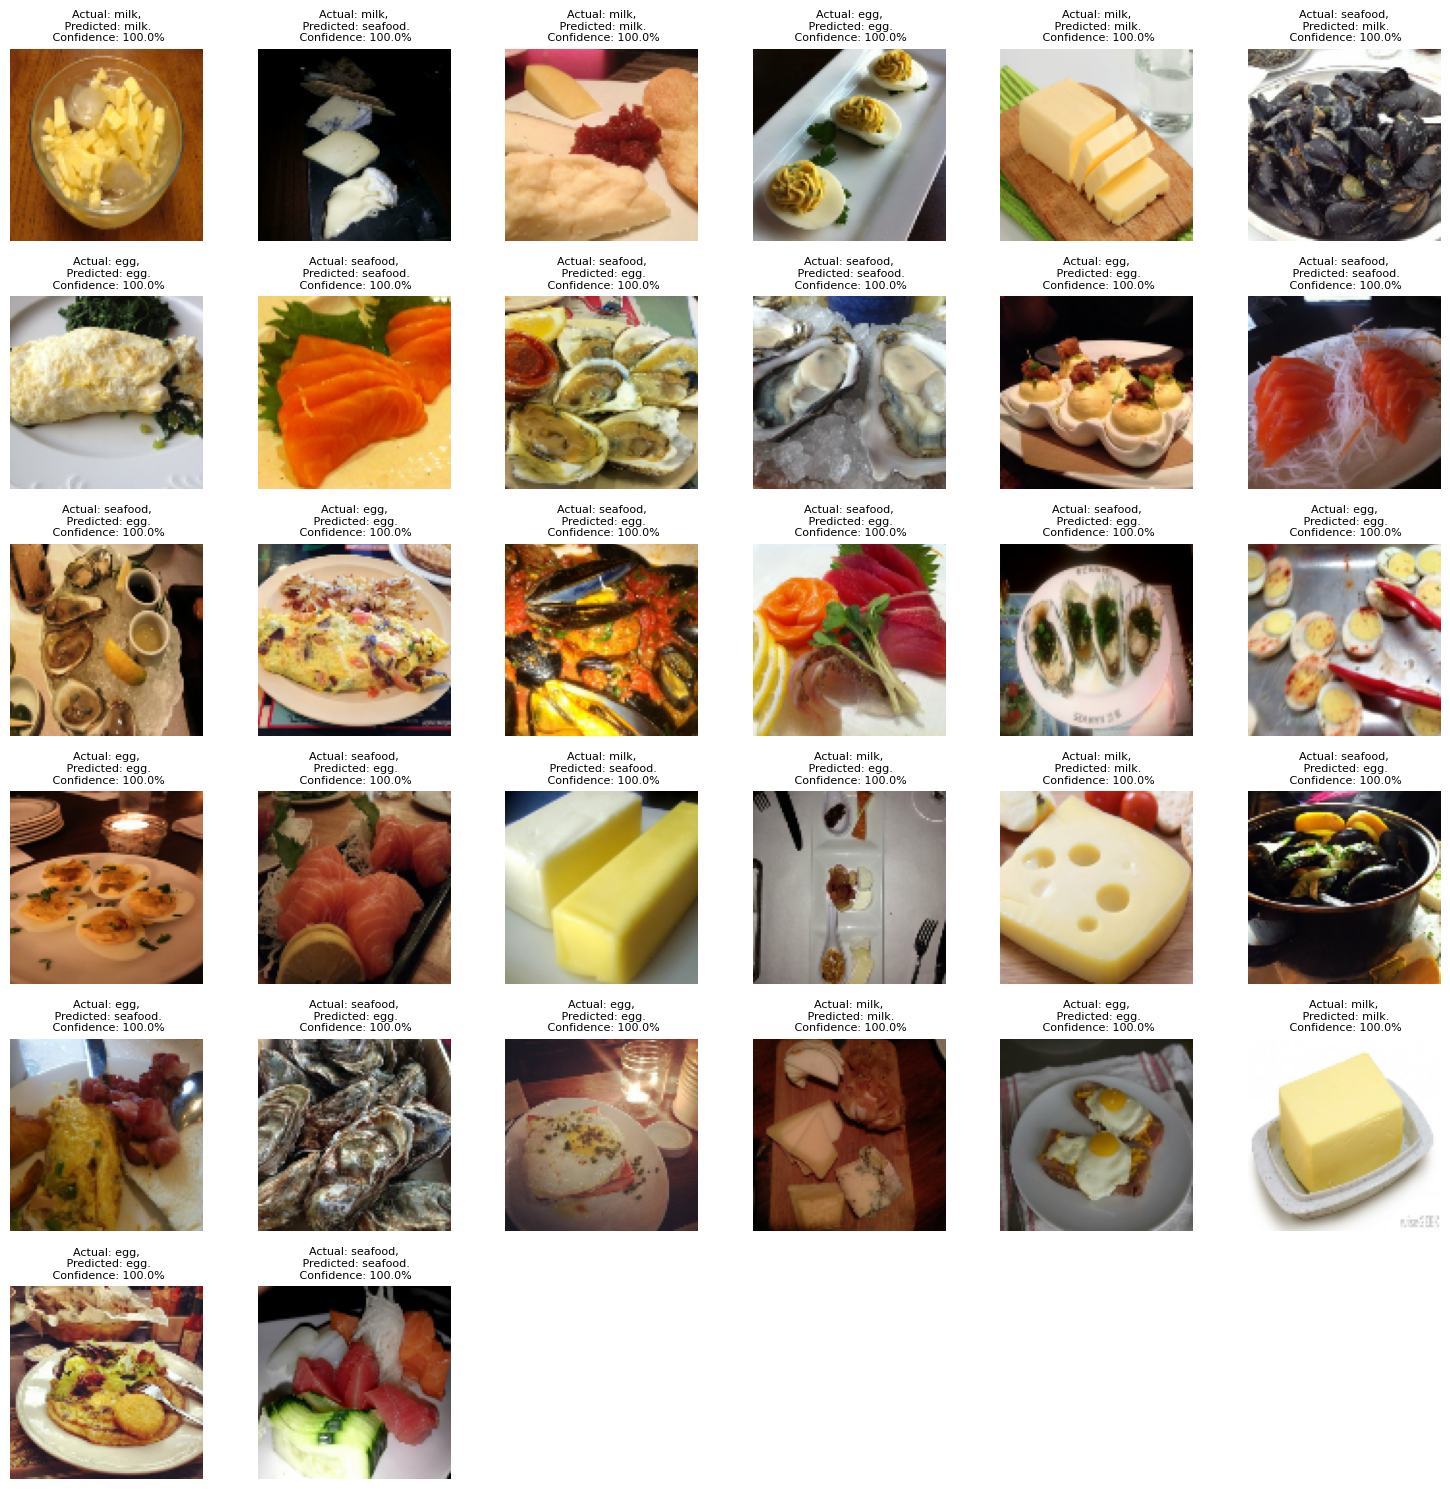

In [34]:
plt.figure(figsize=(15, 15))

# Iterate over the batches and then the images to display their predictions
batch_size = 32
for images, labels in test_dataset.take(12):
    for i in range(batch_size):
        if i >= len(images):
            break

        ax = plt.subplot(6, 6, i + 1)
        image = tf.image.resize(images[i], (100, 100))
        plt.imshow(image.numpy().astype("uint8"))
        predicted_class, confidence = predict(model_VGG16, images[i].numpy())
        actual_class = ts_class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%", fontsize=8)
        plt.axis("off")

    # If there are more than batch size images, break out of the loop
    if i >= batch_size - 1:
        break

# Hide any empty subplots
for i in range(i + 1, batch_size):
    plt.subplot(6,6, i + 1)
    plt.axis("off")

plt.tight_layout()
plt.show()

ValueError: Multioutput target data is not supported with label binarization

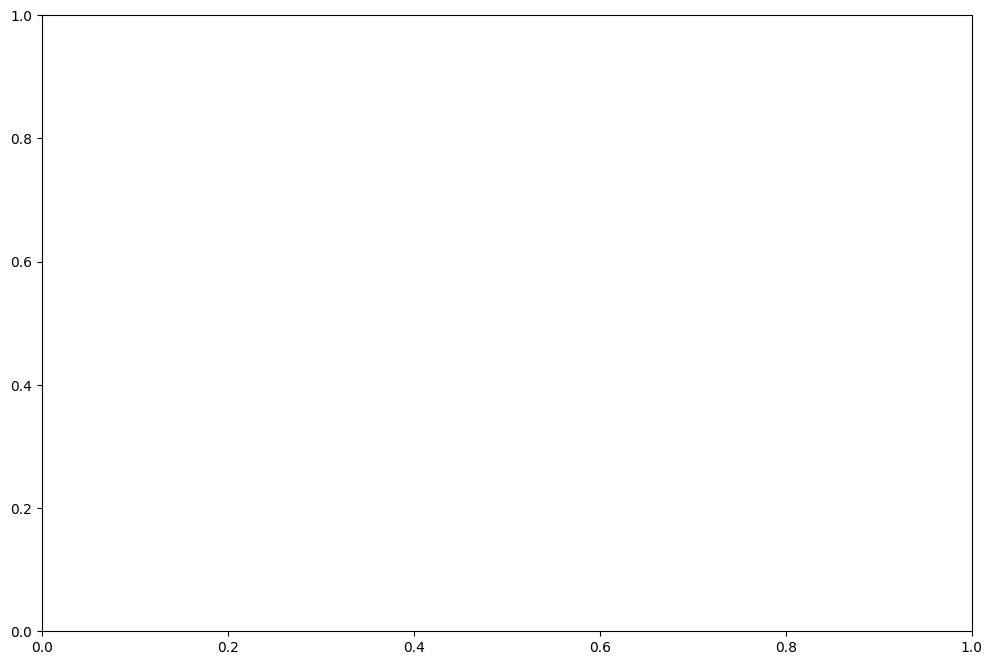

In [67]:
# import matplotlib.pyplot as plt 
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.metrics import roc_curve, auc, roc_auc_score


# target= ['egg', 'milk', 'seafood']

# # set plot figure size
# fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# # function for scoring roc auc score for multi-class
# def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#     lb = LabelBinarizer()
#     lb.fit(y_test)
#     y_test = lb.transform(y_test)
#     y_pred = lb.transform(y_pred)

#     for (idx, c_label) in enumerate(target):
#         fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
#         c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
#     c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
#     return roc_auc_score(y_test, y_pred, average=average)


# print('ROC AUC score:', multiclass_roc_auc_score(ytest, ypred))

# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# plt.show()

In [ ]:
class_dict=test_generator.class_indices
class_dict

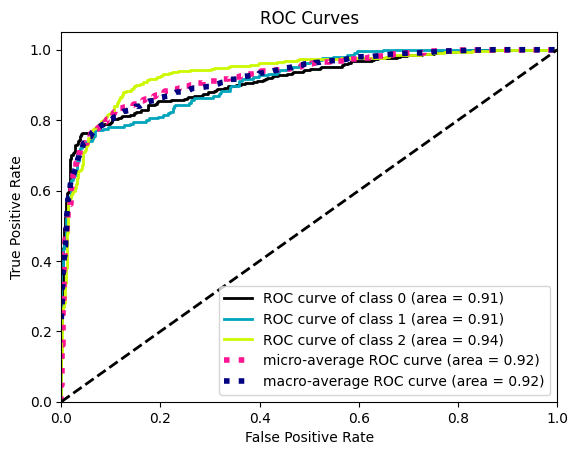

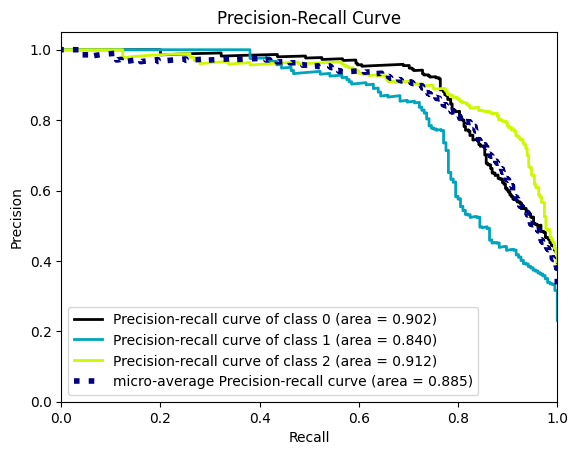

In [70]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_true = y_actual
y_probas = preds
skplt.metrics.plot_roc_curve(y_true, y_probas)
skplt.metrics.plot_precision_recall_curve(y_true, y_probas)
plt.show()

In [ ]:
# model_VGG16.save('Model.VGG16_new2')

In [ ]:
# model_VGG16 = models.load_model('Model.VGG16_new2')